# Natural Language Processing - Fake News Detection with LIAR dataset

Dataset [source](https://paperswithcode.com/dataset/liar)

## Import necessary libraries

- `pandas` for data manipulation (reading dataset and manipulation)
- `nltk` for Natural Language Processing stuff 
- `re` for applying regular expressions (RegEx)
- `sklearn` (scikit-learn) for checking accuracy through accuracy score and for some algorithms

In [1]:
import re
import string

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amoghshakya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amoghshakya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amoghshakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Reading the dataset

The dataset from LIAR dataset is actually in `tsv` (Tab Separated Values) format. So, we can use the `sep` argument in `pandas.read_csv()` method to read values separated by `\t` (tabs).

> *(preprocessing step)*
>
> There are no columns in the dataset (bummer). We can assign them columns provided from the README file (of the dataset).

In [2]:
# read dataset
dataset_folder = "./liar_dataset"

# re-reading for experimenting
def read_dataset() -> tuple[3]:
    # these are tsv files, so put separator as '\t'
    train_df = pd.read_csv(f"{dataset_folder}/train.tsv", sep="\t")
    test_df = pd.read_csv(f"{dataset_folder}/test.tsv", sep="\t")
    valid_df = pd.read_csv(f"{dataset_folder}/valid.tsv", sep="\t")

    # define columns 

    columns = ["id", "label", "statement", "subject", "speaker", 
               "speaker_job", "state_info", "party_affiliation", 
               "barely_true_counts", "false_counts", "half_true_counts", 
               "mostly_true_counts", "pants_on_fire_counts", "context"]
    
    train_df.columns = columns
    test_df.columns = columns
    valid_df.columns = columns

    return train_df, test_df, valid_df

train_df, test_df, valid_df = read_dataset()

In [3]:
train_df

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10235,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10236,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10237,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


## Preprocessing

In [4]:
print(train_df.columns)
print(test_df.columns)
print(valid_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')
Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')
Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


### Define preprocessing functions

Here, we define the functions that we are going to apply to the dataset.

In [5]:
train_df['label'].unique()

array(['half-true', 'mostly-true', 'false', 'true', 'barely-true',
       'pants-fire'], dtype=object)

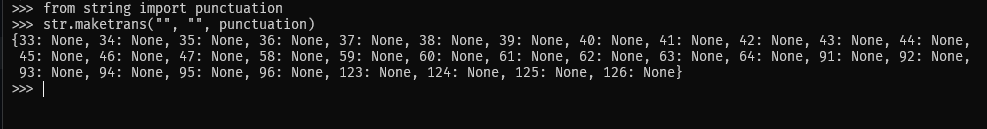

In [6]:
def preprocess_text(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    text = text.lower()
    # TLDR; translate is just a fancier replace method
    # The translate() method returns a string where some specified characters are replaced 
    # with the character described in a dictionary, or in a mapping table.
    # The maketrans() method returns a mapping table that can be used with the translate() 
    # method to replace specified characters. The third parameter is a string describing what characters to remove.
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    processed_text = " ".join(tokens)
    return processed_text

def numero_labelo(label: str) -> str:
    # binary labeling because it's not fake if it's half true
    return 1 if label in ["half-true", "mostly-true", "true"] else 0

In [7]:
# example
print(preprocess_text(text="Bloody-mindedness, and the understanding that it's analog, not digital. \
                        You won't go from unable to able; you'll go from unable to more able, progressively, \
                        for as long as you remain bloody-minded about continually working on it."))

# Quote by Kevin Malone (from what he intended)
print(preprocess_text("Why waste time saying a lot of words when few words can do the trick?"))

# Convert Label example
print(numero_labelo("half-true"))
print(numero_labelo("barely-true"))

bloodymindedness understanding analog digital wont go unable able youll go unable able progressively long remain bloodyminded continually working
waste time saying lot word word trick
1
0


### Applying the methods

In [8]:
train_df['processed_statement'] = train_df['statement'].apply(preprocess_text)

In [9]:
train_df['label_encoded'] = train_df['label'].apply(numero_labelo)

#### Apply to test and validation datasets as well

In [10]:
test_df['processed_statement'] = test_df['statement'].apply(preprocess_text)
test_df['label_encoded'] = test_df['label'].apply(numero_labelo)
valid_df['processed_statement'] = valid_df['statement'].apply(preprocess_text)
valid_df['label_encoded'] = valid_df['label'].apply(numero_labelo)

## Vectorization

...

In [11]:
# merge statements
all_statements = pd.concat([train_df['processed_statement'], valid_df['processed_statement']])

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
vectorizer.fit(all_statements)

X_train = vectorizer.fit_transform(train_df['processed_statement'])
X_valid = vectorizer.transform(valid_df['processed_statement'])
X_test = vectorizer.transform(test_df['processed_statement'])

## Training Models

In [12]:
# train model
model = LogisticRegression()
model.fit(X_train, train_df['label_encoded'])

# validate model
y_valid_pred = model.predict(X_valid)
print(f"Validation accuracy: {accuracy_score(valid_df['label_encoded'], y_valid_pred)}")
print(classification_report(valid_df['label_encoded'], y_valid_pred))

# test the model
y_test_pred = model.predict(X_test)
print(f"Test accuracy: {accuracy_score(test_df['label_encoded'], y_test_pred)}")
print(classification_report(test_df['label_encoded'], y_test_pred))

Validation accuracy: 0.6141855027279813
              precision    recall  f1-score   support

           0       0.63      0.47      0.54       615
           1       0.61      0.74      0.67       668

    accuracy                           0.61      1283
   macro avg       0.62      0.61      0.60      1283
weighted avg       0.62      0.61      0.61      1283

Test accuracy: 0.6105845181674565
              precision    recall  f1-score   support

           0       0.57      0.43      0.49       553
           1       0.63      0.75      0.68       713

    accuracy                           0.61      1266
   macro avg       0.60      0.59      0.59      1266
weighted avg       0.60      0.61      0.60      1266



In [13]:
# Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, train_df['label_encoded'])

y_valid_pred = nb_classifier.predict(X_valid)
print("Validation set performance: ", accuracy_score(valid_df['label_encoded'], y_valid_pred))
print(classification_report(valid_df['label_encoded'], y_valid_pred))

y_test_pred = nb_classifier.predict(X_test)
print("Test set performance: ", accuracy_score(test_df['label_encoded'], y_test_pred))
print(classification_report(test_df['label_encoded'], y_test_pred))

Validation set performance:  0.6048324240062354
              precision    recall  f1-score   support

           0       0.63      0.43      0.51       615
           1       0.59      0.77      0.67       668

    accuracy                           0.60      1283
   macro avg       0.61      0.60      0.59      1283
weighted avg       0.61      0.60      0.59      1283

Test set performance:  0.6129541864139021
              precision    recall  f1-score   support

           0       0.58      0.40      0.47       553
           1       0.63      0.78      0.69       713

    accuracy                           0.61      1266
   macro avg       0.60      0.59      0.58      1266
weighted avg       0.61      0.61      0.60      1266



## Is the dataset biased?

Since the dataset is already provided splitted into train, test, and validation, could it be split in bias?

Here, we're going to concat them and split them again randomly to see if they yield better results.

In [14]:
train_df, test_df, valid_df = read_dataset()

In [15]:
print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)

(10239, 14)
(1266, 14)
(1283, 14)


In [16]:
all_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)

all_df.shape

(12788, 14)

In [17]:
X = all_df['statement'].apply(preprocess_text)
y = all_df['label'].apply(numero_labelo)

### Split Ratio

We're going to split the dataset into 8:1:1 ratio.

- 80% for training
- 10% for validation
- 10% for testing

[Answer to life, the universe, and everything](https://www.google.com/search?q=what+is+the+answer+to+life+the+universe+and+everything&sca_esv=0f377be67df6cd70&sxsrf=ADLYWIJ-zE-JGgkX3L96BTR--kiHVhcnvw%3A1720336223275&ei=Xz-KZobCEOnF1e8Pnry2yAc&oq=what+is+the+answer+to+life%2C+&gs_lp=Egxnd3Mtd2l6LXNlcnAiHHdoYXQgaXMgdGhlIGFuc3dlciB0byBsaWZlLCAqAggAMgoQABiABBgUGIcCMgoQABiABBgUGIcCMgoQABiABBhDGIoFMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjZOlD1FVijNXACeAGQAQCYAbUBoAGkIaoBBDAuMjm4AQPIAQD4AQGYAh-gAtIiwgIKEAAYsAMY1gQYR8ICDRAAGIAEGLADGEMYigXCAg4QABiwAxjkAhjWBNgBAcICExAuGIAEGLADGEMYyAMYigXYAQLCAhYQLhiABBiwAxhDGNQCGMgDGIoF2AECwgIKECMYgAQYJxiKBcICBBAjGCfCAg0QLhiABBhDGNQCGIoFwgIQEAAYgAQYsQMYQxiDARiKBcICCxAAGIAEGLEDGIMBwgIIEAAYgAQYsQPCAgUQLhiABMICEBAAGIAEGLEDGEMYyQMYigXCAgsQABiABBiSAxiKBcICChAuGIAEGEMYigXCAgsQABiABBiRAhiKBZgDAIgGAZAGELoGBggBEAEYCboGBggCEAEYCJIHBDIuMjmgB4GYAg&sclient=gws-wiz-serp)

In [18]:
print(f"Total: {all_df.shape[0]}")
print(f"Train: {all_df.shape[0] * 0.8}")
print(f"Test: {all_df.shape[0] * 0.1}")
print(f"Valid: {all_df.shape[0] * 0.1}", end="\n\n")

# 20% because test(10%) + validation(10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=37)
print(f"X_train shape: {len(X_train)}")
print(f"X_temp shape: {len(X_temp)}")
print(f"y_train shape: {len(y_train)}")
print(f"y_temp shape: {len(y_temp)}")

Total: 12788
Train: 10230.400000000001
Test: 1278.8000000000002
Valid: 1278.8000000000002

X_train shape: 10230
X_temp shape: 2558
y_train shape: 10230
y_temp shape: 2558


In [19]:
# again split the 20% to test and valid by half (get 10% & 10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=37)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 10230
Testing set size: 1279
Validation set size: 1279


In [20]:
del X_temp, y_temp

### Vectorization (again)

In [21]:
X_train_vec = vectorizer.fit_transform(X_train)
X_valid_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

### Models (again)

In [22]:
# LogisticRegression
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# validate model
y_valid_pred = model.predict(X_valid_vec)
print(f"Validation accuracy: {accuracy_score(y_val, y_valid_pred)}")
print(classification_report(y_val, y_valid_pred))

# test the model
y_test_pred = model.predict(X_test_vec)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))

Validation accuracy: 0.6239249413604379
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       542
           1       0.66      0.73      0.69       737

    accuracy                           0.62      1279
   macro avg       0.61      0.60      0.60      1279
weighted avg       0.62      0.62      0.62      1279

Test accuracy: 0.6254886630179828
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       545
           1       0.65      0.73      0.69       734

    accuracy                           0.63      1279
   macro avg       0.61      0.61      0.61      1279
weighted avg       0.62      0.63      0.62      1279



In [23]:
# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

y_valid_pred = nb_classifier.predict(X_valid_vec)
print("Validation set performance: ", accuracy_score(y_val, y_valid_pred))
print(classification_report(y_val, y_valid_pred))

y_test_pred = nb_classifier.predict(X_test_vec)
print("Test set performance: ", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Validation set performance:  0.6293979671618452
              precision    recall  f1-score   support

           0       0.58      0.45      0.51       542
           1       0.65      0.76      0.70       737

    accuracy                           0.63      1279
   macro avg       0.62      0.61      0.60      1279
weighted avg       0.62      0.63      0.62      1279

Test set performance:  0.6293979671618452
              precision    recall  f1-score   support

           0       0.59      0.45      0.51       545
           1       0.65      0.76      0.70       734

    accuracy                           0.63      1279
   macro avg       0.62      0.61      0.61      1279
weighted avg       0.62      0.63      0.62      1279



## Exploring other models

In [24]:
X = vectorizer.fit_transform(X)
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)

In [25]:
svc = SVC(probability=True)
log_reg = LogisticRegression()
nb_clf = MultinomialNB()

In [26]:
voting_clf = VotingClassifier(estimators=[('lr', log_reg), ('svc', svc), ('nb_clf', nb_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('svc', SVC(probability=True)),
                             ('nb_clf', MultinomialNB())],
                 voting='soft')

In [27]:
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy: 0.6598905394839718
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       523
           1       0.69      0.77      0.73       756

    accuracy                           0.66      1279
   macro avg       0.65      0.64      0.64      1279
weighted avg       0.65      0.66      0.65      1279

